# 7.2: Examining `G.fst` with `openFST` 
## (in `python` with `pywrapfst`)

`openFST` has a `python` wrapper called [`pywrapfst`](http://www.openfst.org/twiki/bin/view/FST/PythonExtension) that gives us *most* of the functionality of `openFST` but from inside `python`.

In [2]:
# because of the way `kaldi` installed `openFST` we have to add the path to the python functions here
import sys
sys.path.append("/home/kaldi/tools/openfst-1.6.2/lib/python2.7/site-packages")    

import re
# from utils/fst_manipulate import fst_manipulate as fstman

import pywrapfst as openfst  # the wrapper module
import graphviz as dot   # a wrapper for graphviz, which will allow us to visualize

## read in the `fst`

Using `Fst.read()` we can load the `fst` into an easy-to-read format with the following structure:

 - TODO

In [3]:
fst_in = openfst.Fst.read("resource_files/fst/animal_fst-2_gram.fst")
print(fst_in)

3	2	<s>	0
0	1	</s>	2.95194
0	4	the	1.34249
0	5	mouse	3.10607
0	6	ate	2.18979
0	7	cheese	3.10607
0	8	cat	2.95194
0	9	and	2.49994
0	10	dog	2.95194
0	11	lion	2.95194
0	12	tyrannosaurus	3.10607
0	13	rex	3.10607
0	14	human	4.20468
0	15	shot	4.20468
0	16	<unk>	2.18979
1	0
2	0	<eps>	1.60944
2	4	the	0.427346
4	0	<eps>	1.76766
4	5	mouse	2.04333
4	7	cheese	2.04333
4	8	cat	1.86265
4	10	dog	1.86265
4	11	lion	1.86265
4	12	tyrannosaurus	2.04333
4	14	human	3.61421
5	0	<eps>	0.810931
5	1	</s>	2.00747
5	4	the	1.48194
5	6	ate	1.82721
5	9	and	1.35206
6	0	<eps>	2.70805
6	4	the	0.0505077
7	0	<eps>	1.25276
7	1	</s>	1.84654
7	9	and	0.519392
8	0	<eps>	0.916291
8	1	</s>	2.11283
8	4	the	1.5873
8	6	ate	1.40741
8	9	and	1.45742
9	0	<eps>	2.39789
9	4	the	0.0695268
10	0	<eps>	0.916291
10	1	</s>	2.11283
10	4	the	1.5873
10	6	ate	1.06486
10	9	and	2.01864
11	0	<eps>	1.09861
11	1	</s>	2.05164
11	6	ate	0.730316
11	9	and	1.97707
12	0	<eps>	1.79176
12	13	rex	0.173406
13	0	<eps>	1.25276
13	1	</s>	1.84654
13	6	ate	0.505155
14

## write to `.dot`

We can then write this `fst` into a `.dot` (from `graphviz`) format

In [3]:
fst_in.draw("resource_files/fst/animal_fst-2_gram.dot")

Unfortunately, the default setting is to write the `.dot` so that the image is in `landscape` format.

In [4]:
%%bash
head resource_files/fst/animal_fst-2_gram.dot

digraph FST {
rankdir = LR;
size = "8.5,11";
label = "";
center = 1;
orientation = Landscape;
ranksep = "0.4";
nodesep = "0.25";
3 [label = "3", shape = circle, style = bold, fontsize = 14]
	3 -> 2 [label = "<s>:<s>", fontsize = 14];


This doesn't visualize well in these notebooks, so the `python` method below will *wrap* both the `FST.draw()` command along with an in-place edit of the `.dot` file to `orientation = Portrait`.

In [5]:
def write_wrapper(fst_, path_out):
    """
    Wraps the native `.draw()` method from `pywrapfst`, 
    but edits the `.dot` file in place to be in portrait mode for easier viewing in notebook
    """
    # write out
    fst_.draw(path_out)
    # read in
    dot_in = open(path_out, "r").read()
    # edit orientation
    dot_out = re.sub(r'Landscape', 'Portrait', dot_in)
    with open(path_out, "w") as f:
        f.write(dot_out)
    

In [6]:
write_wrapper(fst_in, "resource_files/fst/animal_fst-2_gram.dot")

## visualize `fst`

Then we can visualize the `.dot` version of our `fst`

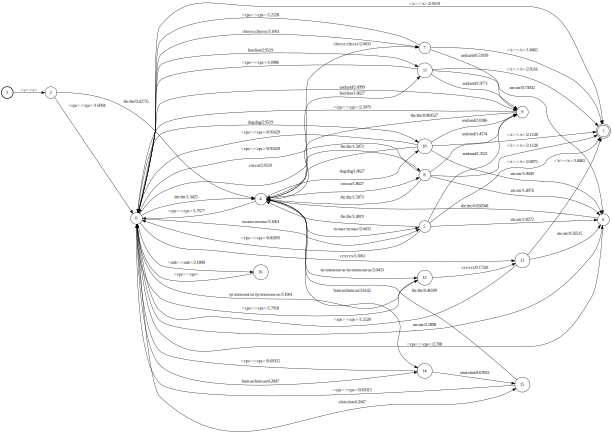

In [7]:
dot.Source.from_file("resource_files/fst/animal_fst-2_gram.dot")

**Note:** You may prefer to render the `.dot` in your browser using a site like http://www.webgraphviz.com/.  Just copy the `.dot` text from `resource_files/fst/animal_fst-2_gram.dot`.

## analyzing the `fst`


Now that we've generated an `fst` to represent our language model, let's look at what's happening.

### `probability` values in `fst` v. equivalent values in language model

The first thing to notice is that the `fst` uses `negative` `log, base e` values whereas our original `ARPA` language model used `log, base 10` values.  You can **roughly** convert the values from the `fst` to the values in the language model with the following:

$language\_model\_value = -(fst\_value / 2.303)$

In [10]:
# looking up a word in table
fst_in.input_symbols().find("<s>")

1

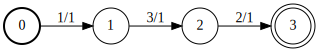

In [5]:
# building a sentence as fst
test_sentence = openfst.Fst()
s0 = test_sentence.add_state()
test_sentence.set_start(s0)
s1 = test_sentence.add_state()
test_sentence.add_arc(
    s0,                      # starting node
    openfst.Arc(             # arc
        ilabel=1, 
        olabel=1, 
        weight=1.0, 
        nextstate=s1
    )   
)
s2 = test_sentence.add_state()
test_sentence.add_arc(
    s1,
    openfst.Arc(
        ilabel=3,
        olabel=3,
        weight=1.0,
        nextstate=s2
    )
)
s3 = test_sentence.add_state()
test_sentence.add_arc(
    s2,
    openfst.Arc(
        ilabel=2,
        olabel=2,
        weight=1.0,
        nextstate=s3
    )
)
test_sentence.set_final(s3)

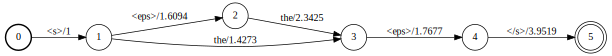

In [6]:
# checking if a sentence is valid
openfst.compose(fst_in, test_sentence)

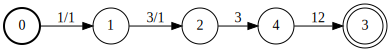

In [7]:
test_sentence.delete_arcs(2)
s4 = test_sentence.add_state()
test_sentence.add_arc(
    s2,
    openfst.Arc(
        ilabel=3,
        olabel=3,
        weight=None,
        nextstate=s4
    )
)
test_sentence.add_arc(
    s4,
    openfst.Arc(
        ilabel=fst_in.input_symbols().find("rex"),
        olabel=fst_in.input_symbols().find("rex"),
        weight=None,
        nextstate=s3
    )
)

In [8]:
openfst.compose(fst_in, test_sentence)

In [49]:
def lookup_word(word, sym_table):
    """
    Gets the index for a word from an existing symbol table
    :param word: <str> to lookup
    :param sym_table: symbol table from existing fst
                        existing_fst.input_symbols()
    :return: <int>
    """
    try:
        return sym_table.find(word)
    except:
        raise Exception("{} not in symbols".format(word))
        
        
def sequence_to_fst(sentence_string, sym_table):
    """

    :param sentence_string:
    :param sym_table:
    :return:
    """
    # initialize the fst
    sentence_fst = openfst.Fst()
    states = {}
    # add start state
    states["start"] = sentence_fst.add_state()
    sentence_fst.set_start(states["start"])

    # convert sentence <str> to <list> of indexes
    #  add <s>
    sentence_idxs = [lookup_word("<s>", sym_table)]
    # add words in 
    sentence_idxs.extend([lookup_word(w, sym_table) for w in sentence_string.lower().split()])
    sentence_idxs.append(lookup_word("</s>", sym_table))

    # add nodes and arcs for sentence
    for i in range(len(sentence_idxs)):
        if i == len(sentence_idxs) - 1:
            break
        states[i] = sentence_fst.add_state()
        idx = sentence_idxs[i]
        if i == 0:
            # for start state
            sentence_fst.add_arc(
                states["start"],
                openfst.Arc(
                    ilabel=idx,
                    olabel=idx,
                    weight=None,
                    nextstate=states[0]
                )
            )
        elif i != len(sentence_idxs) - 1:
            sentence_fst.add_arc(
                states[i-1],
                openfst.Arc(
                    ilabel=idx,
                    olabel=idx,
                    weight=None,
                    nextstate=states[i]
                )
            )

    # add end state
    states["end"] = sentence_fst.add_state()
    sentence_fst.set_final(states["end"])
    # add final arc
    sentence_fst.add_arc(
        states[i-1],
        openfst.Arc(
            ilabel=sentence_idxs[-1],
            olabel=sentence_idxs[-1],
            weight=None,
            nextstate=states["end"]
            )
        )
    return sentence_fst

def check_sequence(seq_string, lm_fst):
    """
    Checks a sequence against the language model representing the language model
    If the sequence is valid, it will return the composed FST
    If the sequence is not valid, will return None
    :param seq_string: <str> of the sequence
    :param lm_fst: <openfst.Fst> representing the language model
    :return: <openfst.Fst> or None
    """
    seq_fst = sequence_to_fst(seq_string, lm_fst.input_symbols())
    return openfst.compose(lm_fst, seq_fst)

In [50]:
sentence = sequence_to_fst("the rex ate the human", fst_in.input_symbols())
list(sentence.states())

[0, 1, 2, 3, 4, 5, 6, 7]

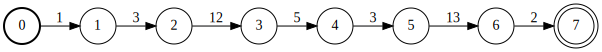

In [51]:
sentence

In [52]:
check_sequence("rex ate the human", fst_in)